In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import statsmodels.api as sm
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler

### Задача 1

In [2]:
dtApple = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=AESKB1ZIQHNO8LWU&datatype=csv", sep=',')
dtGoogle = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GOOGL&outputsize=full&apikey=AESKB1ZIQHNO8LWU&datatype=csv", sep=',')
dtFacebook = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=FB&outputsize=full&apikey=AESKB1ZIQHNO8LWU&datatype=csv", sep=',')

dtApple, dtGoogle, dtFacebook

(       timestamp    open    high     low   close    volume
 0     2020-05-29  319.25  321.15  316.47  317.94  38399532
 1     2020-05-28  316.77  323.44  315.63  318.25  33449103
 2     2020-05-27  316.14  318.71  313.09  318.11  28236274
 3     2020-05-26  323.50  324.24  316.50  316.73  31380454
 4     2020-05-22  315.77  319.23  315.35  318.89  20450754
 ...          ...     ...     ...     ...     ...       ...
 5027  2000-06-05   93.31   95.25   89.69   91.31   2889900
 5028  2000-06-02   93.75   99.75   89.00   92.56   7079000
 5029  2000-06-01   81.75   89.56   80.37   89.12   8070000
 5030  2000-05-31   86.87   91.25   83.81   84.00   3870600
 5031  2000-05-30   87.62   88.12   81.75   87.56   6366600
 
 [5032 rows x 6 columns],
        timestamp     open     high      low     close    volume
 0     2020-05-29  1420.43  1436.73  1415.98  1433.520   1852522
 1     2020-05-28  1400.00  1444.46  1399.08  1418.240   1759787
 2     2020-05-27  1420.00  1425.35  1394.60  1420.280   

### Задача 2

#### Посчитаем daily returns для данных акций по формуле $r_i=\frac{P_{i+1}-P_i}{P_i}$ и добавим столбец в наши таблички

In [3]:
for dt in (dtApple, dtGoogle, dtFacebook):
    dt['timestamp'] = dt['timestamp'].astype('datetime64')
    dt['daily_returns'] = None
    for i in range(len(dt)-1):
        dt['daily_returns'][i] = float((dt['close'][i+1] - dt['close'][i])/dt['close'][i])
    dt['daily_returns'] = dt['daily_returns'].astype('float64')
    dt

/Users/anatoliy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Так как данные по акциям Facebook доступны только начиная с 21 мая 2012 года, будем далее анализировать все акции за такой же период.

#### Взглянем на поведение самих котировок

/Users/anatoliy/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


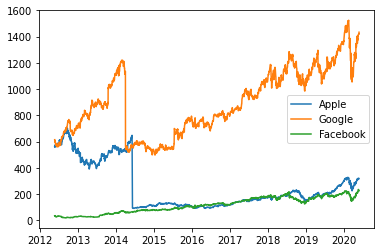

In [4]:
for dt in (dtApple, dtGoogle, dtFacebook):
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    plt.plot(dt['timestamp'], dt['close'])
plt.legend(('Apple', 'Google', 'Facebook'))
plt.show()

 #### Посмотрим, как меняется величина daily return от времени:

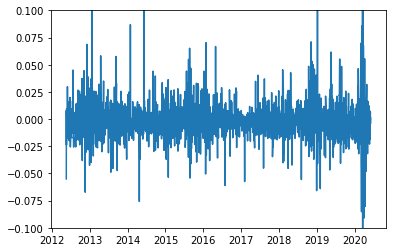

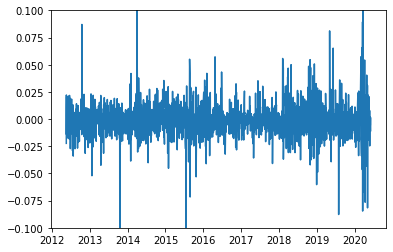

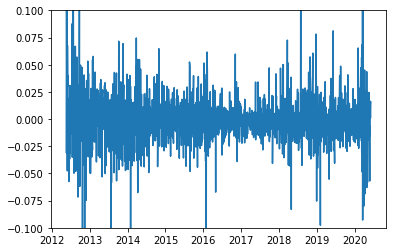

In [5]:
for dt in (dtApple, dtGoogle, dtFacebook):
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    plt.plot(dt['timestamp'], dt['daily_returns'])
    plt.ylim([-0.1, 0.1])
    plt.show()

#### Посчитаем статистики распределения

In [6]:
for i, dt in enumerate((dtApple, dtGoogle, dtFacebook)):
    names = ('Apple', 'Google', 'Facebook')
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    inf = scipy.stats.describe(dt['daily_returns'])
    print(f'{names[i]}:\nДиапазон: {np.array(inf[1]).round(2)}\nСреднее значение: {round(inf[2], 4)}\
    \nДисперсия: {round(inf[3], 4)}\nСмещение: {round(inf[4], 2)}\nЭксцесс: {round(inf[5], 2)}\n')

Apple:
Диапазон: [-0.11  5.89]
Среднее значение: 0.0024    
Дисперсия: 0.0175
Смещение: 43.71
Эксцесс: 1943.16

Google:
Диапазон: [-0.14  0.99]
Среднее значение: -0.0002    
Дисперсия: 0.0007
Смещение: 24.16
Эксцесс: 883.12

Facebook:
Диапазон: [-0.23  0.23]
Среднее значение: -0.0006    
Дисперсия: 0.0005
Смещение: 0.26
Эксцесс: 15.01



Поведение напоминает белый шум, поэтому предположение, что распределение будет нормальным. Однако, из-за высокого коэффициента эксцесса распределения могут не пройти проверку критериями нормальности.

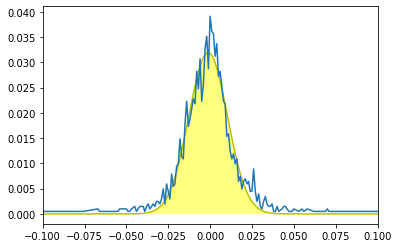

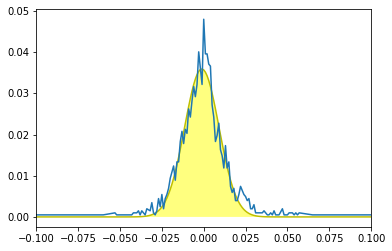

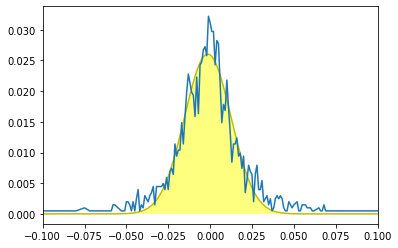

In [7]:
def gaussian(x, amp, cen, sigma):
    return amp*(1/(sigma*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen)/sigma)**2)))

opt = []
err = []
for dt in [dtApple, dtGoogle, dtFacebook]:
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    
    x_array = sorted(list(set(dt['daily_returns'].round(3))))
    y_array = [list(dt['daily_returns'].round(3)).count(x)/len(dt) for x in x_array]
    
    popt_gauss, pcov_gauss = scipy.optimize.curve_fit(gaussian, x_array, y_array)
    perr_gauss = np.sqrt(np.diag(pcov_gauss))
    
    opt.append(popt_gauss)
    err.append(perr_gauss)
    
    gauss_peak = gaussian(x_array, *popt_gauss)
    
    plt.plot(x_array, gauss_peak, "y")
    plt.fill_between(x_array, gauss_peak.min(), gauss_peak, facecolor="yellow", alpha=0.5)
    plt.plot(x_array, y_array)
    plt.xlim([-0.1,0.1])
    plt.show()


Действительно, как мы видим из графиков, распределение неплохо описывается функцией Гаусса

#### Проверим дополнительно нормальность распределения с помощью критериев Харди-Бера и Шапиро:

In [8]:
for dt in [dtApple, dtGoogle, dtFacebook]:
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    print('JB p-value:', sm.stats.stattools.jarque_bera(dt['daily_returns'])[1])
    print('Sh p-value:', scipy.stats.shapiro(dt['daily_returns'])[1], '\n')

JB p-value: 0.0
Sh p-value: 0.0 

JB p-value: 0.0
Sh p-value: 0.0 

JB p-value: 0.0
Sh p-value: 5.495836076727851e-37 



Увы, гипотеза о нормальности распределения не подтверждается

#### Стационарность оценим методом Дики-Фуллера

In [9]:
for dt in [dtApple, dtGoogle, dtFacebook]:
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    adf = sm.tsa.stattools.adfuller(dt['daily_returns'])
    print(f'adf: {adf[0]}\np-value: {adf[1]}\ncritical values: {adf[4]}\n')

adf: -44.98637368739432
p-value: 0.0
critical values: {'1%': -3.4335946172657774, '5%': -2.8629733042364576, '10%': -2.567533028727577}

adf: -44.42441276697151
p-value: 0.0
critical values: {'1%': -3.4335946172657774, '5%': -2.8629733042364576, '10%': -2.567533028727577}

adf: -14.058242509323263
p-value: 3.089539315828132e-26
critical values: {'1%': -3.4336091712699957, '5%': -2.862979729933645, '10%': -2.567536450078678}



Мы видим, что значения adf много меньше критических значений при очень маленьких p-value. Это подтверждает стационарность временного ряда

#### Оценим зависимость между прошлыми и будущими значениями с помощью автокорреляционной функции:

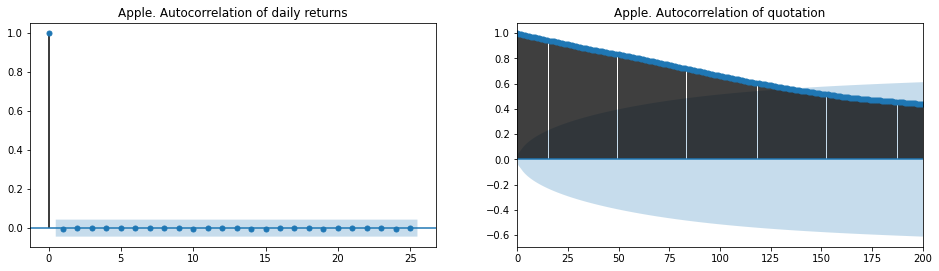

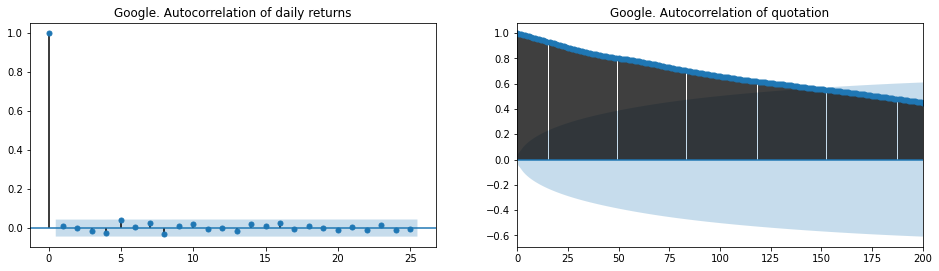

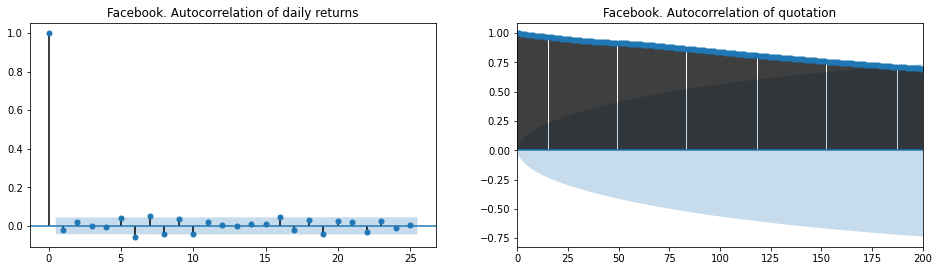

In [10]:
for i, dt in enumerate([dtApple, dtGoogle, dtFacebook]):
    names = ('Apple', 'Google', 'Facebook')
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    fig = plt.figure(figsize = (16,14))
    ax1 = fig.add_subplot(3, 2, 2*i+1)
    sm.graphics.tsa.plot_acf(dt['daily_returns'], lags=25, ax=ax1, title=f'{names[i]}. Autocorrelation of daily returns')
    ax2 = fig.add_subplot(3, 2, 2*i+2)
    sm.graphics.tsa.plot_acf(dt['close'], lags=200, ax=ax2, title=f'{names[i]}. Autocorrelation of quotation')
    plt.xlim([0,200])

Как мы видим, автокорреляции для daily returns не наблюдается; превышающие порог значимости лаги, большие одного, можем наблюдать только для акций Facebook, но эта корреляция незначительна.
Для котировок, напротив, есть сильная автокорреляция 

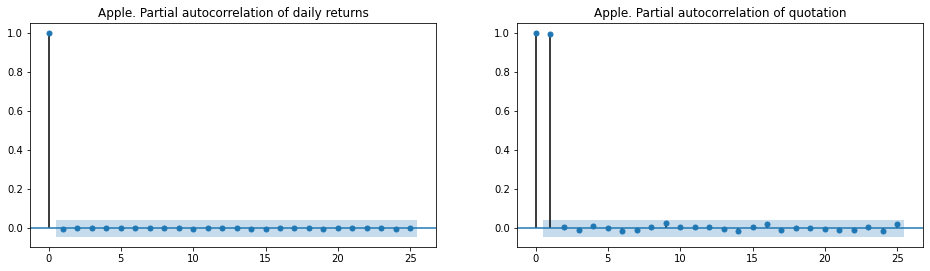

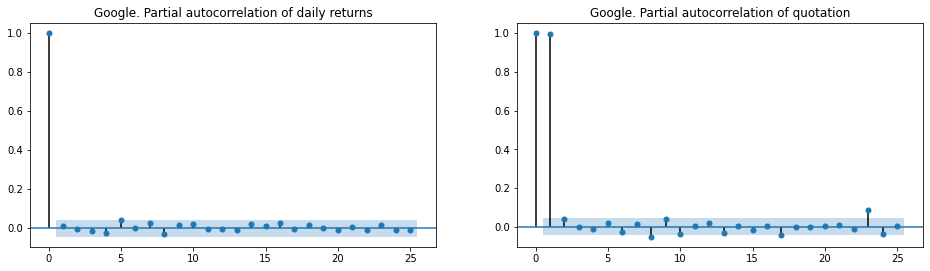

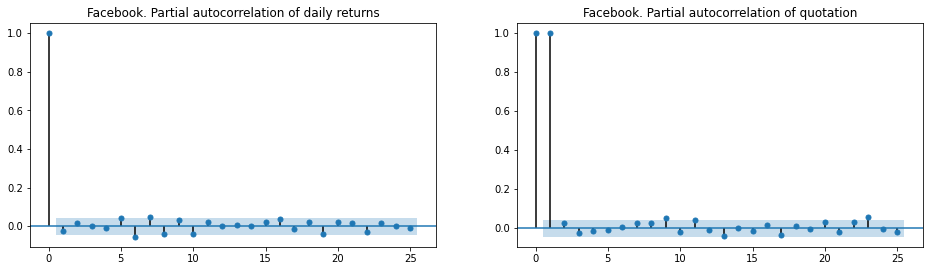

In [11]:
for i, dt in enumerate([dtApple, dtGoogle, dtFacebook]):
    names = ('Apple', 'Google', 'Facebook')
    dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2012, 5, 21)]
    fig = plt.figure(figsize = (16,14))
    ax1 = fig.add_subplot(3, 2, 2*i+1)
    sm.graphics.tsa.plot_pacf(dt['daily_returns'], lags=25, ax=ax1, title=f'{names[i]}. Partial autocorrelation of daily returns')
    ax2 = fig.add_subplot(3, 2, 2*i+2)
    sm.graphics.tsa.plot_pacf(dt['close'], lags=25, ax=ax2, title=f'{names[i]}. Partial autocorrelation of quotation')
    #plt.xlim([130,200])

Для частичной автокорреляции наблюдается аналогичная ситуация

#### Найдем корреляцию Пирсона между временными рядами daily returns для акций Google и Facebook за последний год

In [12]:
scipy.stats.stats.pearsonr(dtGoogle.loc[dtGoogle['timestamp'] >= pd.Timestamp(2019, 5, 21)]['daily_returns'], 
                           dtFacebook.loc[dtFacebook['timestamp'] >= pd.Timestamp(2019, 5, 21)]['daily_returns'])

(0.8218182402937111, 9.812918986891064e-65)

Похоже, что ряды коррелируют между собой

#### Проверить причинную связь между этими рядами с помощью Granger causality test нам не удастся, поскольку, как было показано выше, ряды не автокоррелируют, а значит, этот тест не имеет смысла

### Задача 3

Возьмем для этой задачи акции Apple с начала 2019 года, сгенерируем случайные значения $f_i$, распределенные нормально, и построим графики для $pnl_i = f_i \cdot r_i$ и для их кумулятивной суммы от времени

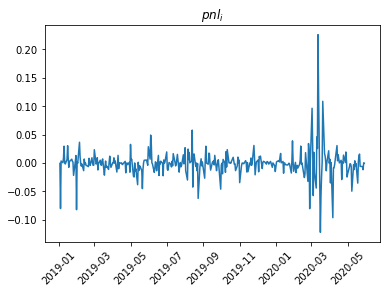

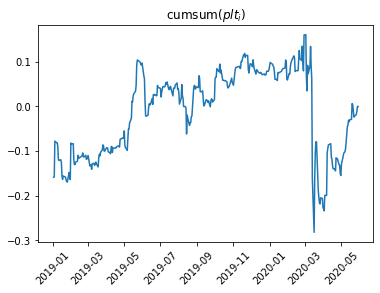

In [13]:
dt1 = dtApple.loc[dtApple['timestamp'] >= pd.Timestamp(2019, 1, 1)]
f_array = []
f_array = (scipy.stats.norm().rvs(size = len(dt1)))
pnl_array = f_array * dt1['daily_returns']
plt.plot(dt1['timestamp'], pnl_array)
plt.title('$pnl_i$')
plt.xticks(rotation=45)
plt.show()

pnl_cumsum = np.cumsum(pnl_array)
plt.plot(dt1['timestamp'], pnl_cumsum)
plt.title('cumsum$(plt_i)$')
plt.xticks(rotation=45)
plt.show()

### Задача 4

In [14]:
SR_array = [[],[],[]]
HR_array = [[],[],[]]

for i, dt in enumerate((dtApple, dtGoogle, dtFacebook)): 
    for j in range(10000):
        dt = dt.loc[dt['timestamp'] >= pd.Timestamp(2019, 5, 21)]
        f_array = (scipy.stats.norm.rvs(opt[i][1], abs(opt[i][2]), len(dt)))
        pnl_array = f_array * dt['daily_returns']
        E_pnl = sum(pnl_array)/len(pnl_array)
        D_pnl = sum((pnl_array - E_pnl)**2)/len(pnl_array)
        SR = E_pnl/(D_pnl**0.5)
        HR = sum((1 + np.sign(f_array * dt['daily_returns']))/2)/len(f_array)
        
        SR_array[i].append(SR)
        HR_array[i].append(HR)

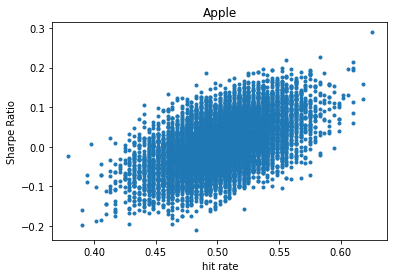

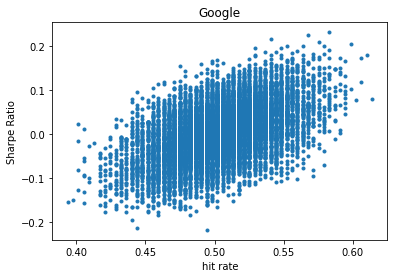

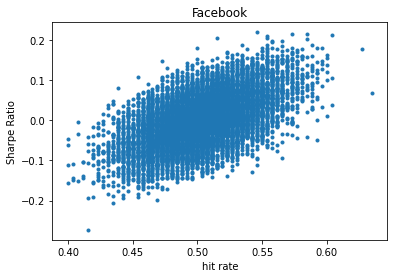

In [15]:
names = ('Apple', 'Google', 'Facebook')
for i in range(3):
    plt.plot(HR_array[i], SR_array[i], linestyle='', marker='.')
    plt.xlabel('hit rate')
    plt.ylabel('Sharpe Ratio')
    plt.title(names[i])
    plt.show()

Получился небольшой диапазон значений hit rate, так как большие и малые значения достигаются крайне редко при случайном выборе f, но общая картина все равно видна